In [24]:
import random
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms.v2 import Compose, Normalize, ToDtype, ToImage

from torch.utils.data import random_split, WeightedRandomSampler

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Architecture class


In [25]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Aqui definimos os atributos da nossa classe
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)

        self.train_loader = None
        self.val_loader = None

        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        self.train_step_fn = self._make_train_step_fn()
        self.val_step_fn = self._make_val_step_fn()

        # para hooks
        self.handles = {}
        self.visualization = {}

    def to(self, device):
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Não foi possível enviar para {device}, enviando para {self.device} em vez disso.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        def perform_train_step_fn(x, y):
            self.model.train()
            yhat = self.model(x)
            loss = self.loss_fn(yhat, y)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            return loss.item()
        return perform_train_step_fn

    def _make_val_step_fn(self):
        def perform_val_step_fn(x, y):
            self.model.eval()
            yhat = self.model(x)
            loss = self.loss_fn(yhat, y)
            return loss.item()
        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        # Removida a lógica do sampler que causava erro, mantendo apenas a seed do torch/numpy/random

    def train(self, n_epochs, seed=42):
        self.set_seed(seed)

        for epoch in range(n_epochs):
            self.total_epochs += 1
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            with torch.no_grad():
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            print(f"Epoch {self.total_epochs}/{n_epochs}: Training Loss = {loss:.4f}, Validation Loss = {val_loss:.4f}")

    # Removidos save_checkpoint e load_checkpoint por não serem essenciais para o fluxo principal

    def predict(self, x):
        self.model.eval()
        with torch.no_grad():
            y_hat_tensor = self.model(x.to(self.device))
        self.model.train()
        return y_hat_tensor.detach().cpu().numpy()

    def count_parameters(self):
      return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    @staticmethod
    def _visualize_tensors(axs, data, labels, predictions=None, cmap=None):
        for i, ax in enumerate(axs):
            ax.imshow(data[i], cmap=cmap)
            ax.axis('off')
            title = f"Label: {labels[i]}"
            if predictions is not None:
                title += f"\nPred: {predictions[i]}"
            ax.set_title(title, fontsize=8)

    def _hook_fn(self, name):
        def hook(module, input, output):
            if name not in self.visualization:
                self.visualization[name] = []
            self.visualization[name].append(output.detach().cpu())
        return hook

    def attach_hooks(self, layers_to_hook):
        self.visualization = {} # Clear previous visualizations
        for name, module in self.model.named_modules():
            if name in layers_to_hook:
                self.handles[name] = module.register_forward_hook(self._hook_fn(name))

    def remove_hooks(self):
        for handle in self.handles.values():
            handle.remove()
        self.handles = {}
        self.visualization = {} # Clear captured data after removing hooks

    def visualize_filters(self, layer_name, cmap='gray'):
        if layer_name not in self.model._modules:
            print(f"Layer '{layer_name}' not found in the model.")
            return None

        layer = self.model._modules[layer_name]
        if not isinstance(layer, nn.Conv2d):
            print(f"Layer '{layer_name}' is not a convolutional layer.")
            return None

        weights = layer.weight.data.cpu().numpy()
        n_filters = weights.shape[0]
        n_channels = weights.shape[1]

        fig, axs = plt.subplots(n_filters, n_channels, figsize=(n_channels * 2, n_filters * 2))
        if n_filters == 1 and n_channels == 1:
            axs = np.array([[axs]]) # Ensure axs is 2D for consistency
        elif n_filters == 1 or n_channels == 1:
            axs = axs.reshape(n_filters, n_channels) # Ensure axs is 2D for consistency

        for i in range(n_filters):
            for j in range(n_channels):
                ax = axs[i, j]
                filter_img = weights[i, j]
                ax.imshow(filter_img, cmap=cmap)
                ax.axis('off')
                if j == 0:
                    ax.set_ylabel(f'Filter {i+1}', rotation=90, ha='right')
                if i == 0:
                    ax.set_title(f'Channel {j+1}')
        plt.suptitle(f'Filters for {layer_name}', y=1.02)
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        return fig

    def visualize_outputs(self, layers_to_visualize, y=None, yhat=None, n_images=10):
        figs = []
        for layer_name in layers_to_visualize:
            if layer_name in self.visualization and self.visualization[layer_name]:
                # Take the first batch of outputs for this layer
                layer_outputs_batch = self.visualization[layer_name][0]
                n_images_actual = min(n_images, layer_outputs_batch.shape[0])

                if layer_outputs_batch.dim() == 4: # Convolutional output (batch, channels, height, width)
                    # For visualization, we'll plot each channel as a separate image for selected input images
                    n_channels = layer_outputs_batch.shape[1]
                    fig_height = n_channels * 1.5
                    fig, axs = plt.subplots(n_channels, n_images_actual, figsize=(n_images_actual * 1.5, fig_height))
                    if n_channels == 1: # Handle single channel case to ensure axs is 2D
                        axs = axs.reshape(1, n_images_actual)

                    for img_idx in range(n_images_actual):
                        for c_idx in range(n_channels):
                            ax = axs[c_idx, img_idx]
                            ax.imshow(layer_outputs_batch[img_idx, c_idx].squeeze(), cmap='viridis')
                            ax.axis('off')
                            if img_idx == 0:
                                ax.set_ylabel(f'Channel {c_idx+1}', rotation=90, ha='right')
                            if c_idx == 0:
                                # Show original label/pred for input image if available
                                title = ""
                                if y is not None:
                                    title += f"L:{y[img_idx]}"
                                if yhat is not None:
                                    title += f" P:{yhat[img_idx]}"
                                if title:
                                    ax.set_title(title, fontsize=8)

                    plt.suptitle(f'Feature Maps for Layer: {layer_name}', y=1.02)
                    plt.tight_layout(rect=[0, 0, 1, 0.98])
                    figs.append(fig)

                elif layer_outputs_batch.dim() == 2: # Linear layer output (batch, features)
                    # For linear layers, plot activation values for each image
                    fig, axs = plt.subplots(n_images_actual, 1, figsize=(8, n_images_actual * 0.8))
                    if n_images_actual == 1:
                        axs = [axs] # Ensure axs is iterable
                    for img_idx in range(n_images_actual):
                        ax = axs[img_idx]
                        values = layer_outputs_batch[img_idx].cpu().numpy()
                        ax.bar(range(len(values)), values)
                        ax.set_ylabel(f'Img {img_idx+1}')
                        ax.set_xticks([]) # Remove x-axis ticks for clarity
                        ax.set_yticks([]) # Remove y-axis ticks for clarity
                        # Show original label/pred for input image if available
                        title = ""
                        if y is not None:
                            title += f"Label: {y[img_idx]}"
                        if yhat is not None:
                            title += f" Pred: {yhat[img_idx]}"
                        if title:
                            ax.set_title(title, fontsize=8)
                        ax.tick_params(axis='y', left=False, labelleft=False)

                    plt.suptitle(f'Outputs for Layer: {layer_name}', y=1.02)
                    plt.tight_layout(rect=[0, 0, 1, 0.98])
                    figs.append(fig)
                else:
                    print(f"Unsupported output dimension for layer {layer_name}: {layer_outputs_batch.dim()}")
            else:
                print(f"No visualization data captured for layer: {layer_name}")
        return figs if figs else None # Return list of figures or None

    def correct(self, x, y):
        self.model.eval()
        with torch.no_grad():
            yhat = self.model(x.to(self.device))
            predicted = torch.argmax(yhat, 1)
        self.model.train()
        # Calcula o número total de amostras por classe e o número de amostras corretas por classe
        correct_per_class = torch.zeros(N_CLASSES)
        total_per_class = torch.zeros(N_CLASSES)

        for class_idx in range(N_CLASSES):
            class_mask = (y == class_idx)
            total_per_class[class_idx] = torch.sum(class_mask).item()
            correct_per_class[class_idx] = torch.sum(predicted[class_mask] == class_idx).item()

        results = torch.stack([correct_per_class, total_per_class], dim=1)
        return results

    @staticmethod
    def loader_apply(data_loader, func, **kwargs):
        results = []
        for x_batch, y_batch in data_loader:
            batch_result = func(x_batch, y_batch, **kwargs)
            results.append(batch_result)
        return torch.stack(results).sum(dim=0)


## Data Preparation

In [ ]:

# Configurações do Dataset MNIST
N_CLASSES = 10
BATCH_SIZE = 64

# 1. Define as transformações
transform_composer = Compose([
    ToImage(),
    ToDtype(torch.float32, scale=True),
    Normalize(mean=(0.5,), std=(0.5,))
])

# 2. Carrega os datasets MNIST
print("Baixando MNIST (com SSL desabilitado temporariamente)...")
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform_composer
)

val_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform_composer
)

# 3. Cria os DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)

print("✅ Dataset MNIST carregado com sucesso!")
print(f"Tamanho do dataset de treino: {len(train_dataset)}")
print(f"Tamanho do dataset de validação: {len(val_dataset)}")
print(f"Número de classes: {N_CLASSES}")

Baixando KMNIST (com SSL desabilitado temporariamente)...


RuntimeError: Error downloading train-images-idx3-ubyte.gz:
Tried http://codh.rois.ac.jp/kmnist/dataset/kmnist/, got:
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1010)>


### Configuration

In [ ]:
# Configurações para SVHN
N_CHANNELS = 1   # Imagens em tons de cinza
INPUT_SIZE = 28  # Imagens 28x28 pixels

torch.manual_seed(13)
model_cnn1 = nn.Sequential()

# --- Featurizer mais robusto para SVHN ---
model_cnn1.add_module('conv1', nn.Conv2d(in_channels=N_CHANNELS, out_channels=32, kernel_size=3, padding=1))
model_cnn1.add_module('relu1', nn.ReLU())
model_cnn1.add_module('maxp1', nn.MaxPool2d(kernel_size=2))

model_cnn1.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model_cnn1.add_module('relu2', nn.ReLU())
model_cnn1.add_module('maxp2', nn.MaxPool2d(kernel_size=2))

model_cnn1.add_module('flatten', nn.Flatten())

# --- Classification ---
# Após 2 maxpools: 32x32 -> 16x16 -> 8x8
# 64 canais * 8 * 8 = 4096
model_cnn1.add_module('fc1', nn.Linear(in_features=64 * 8 * 8, out_features=128))
model_cnn1.add_module('relu3', nn.ReLU())
model_cnn1.add_module('dropout', nn.Dropout(0.5))
model_cnn1.add_module('fc2', nn.Linear(in_features=128, out_features=N_CLASSES))

print(f"Parâmetros Totais: {sum(p.numel() for p in model_cnn1.parameters() if p.requires_grad)}")

Parâmetros Totais: 545098


### Training

Iniciando treinamento. Resultados do loss por época:
Dispositivo de treinamento: cpu
Número de parâmetros treináveis: 545,098
Epoch 1/10: Training Loss = 2.2424, Validation Loss = 2.2209
Epoch 2/10: Training Loss = 2.2266, Validation Loss = 2.1965
Epoch 3/10: Training Loss = 2.1342, Validation Loss = 1.8961
Epoch 4/10: Training Loss = 1.5301, Validation Loss = 1.0797
Epoch 5/10: Training Loss = 1.0079, Validation Loss = 0.8672
Epoch 6/10: Training Loss = 0.8151, Validation Loss = 0.6731
Epoch 7/10: Training Loss = 0.7177, Validation Loss = 0.6292
Epoch 8/10: Training Loss = 0.6614, Validation Loss = 0.5792
Epoch 9/10: Training Loss = 0.6178, Validation Loss = 0.5464
Epoch 10/10: Training Loss = 0.5829, Validation Loss = 0.5227


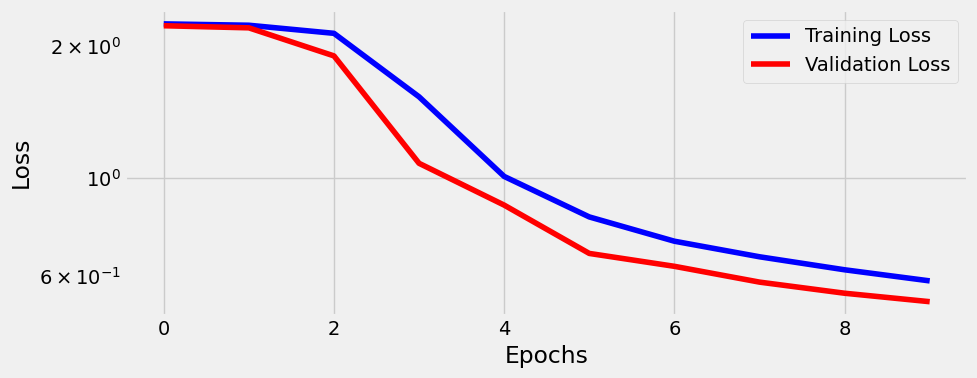

In [30]:
LR = 0.01
N_EPOCHS = 10

# Define loss function and optimizer
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn1 = optim.SGD(model_cnn1.parameters(), lr=LR)

# Cria a arquitetura de treinamento
arch_cnn1 = Architecture(model_cnn1, multi_loss_fn, optimizer_cnn1)

# Define os data loaders
arch_cnn1.set_loaders(train_loader, val_loader)

print("Iniciando treinamento. Resultados do loss por época:")
print(f"Dispositivo de treinamento: {arch_cnn1.device}")
print(f"Número de parâmetros treináveis: {arch_cnn1.count_parameters():,}")

# Inicia o treinamento
arch_cnn1.train(N_EPOCHS)

# Plota as perdas após o treinamento
arch_cnn1.plot_losses()
plt.show()

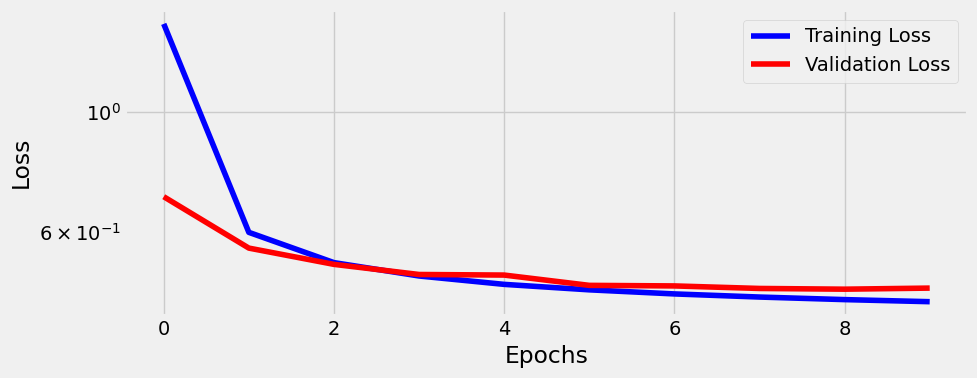

In [6]:
fig = arch_cnn1.plot_losses()

In [7]:
## Visualizing Feature Maps

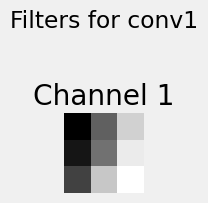


Visualização das Imagens de Entrada:


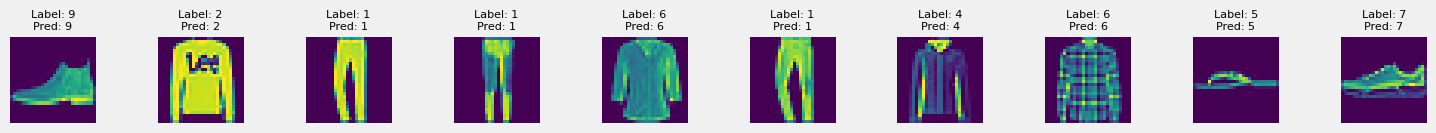


Visualizando Feature Maps (Featurizer - Primeiras 10 Imagens):


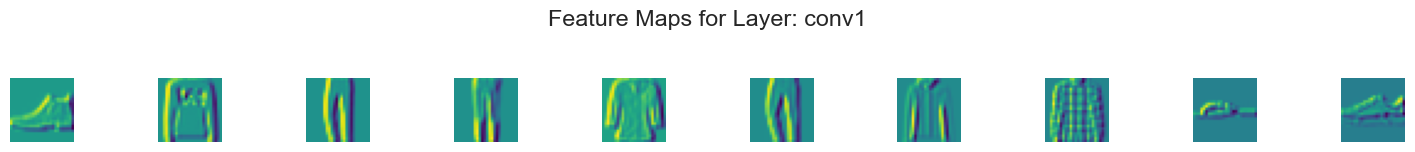

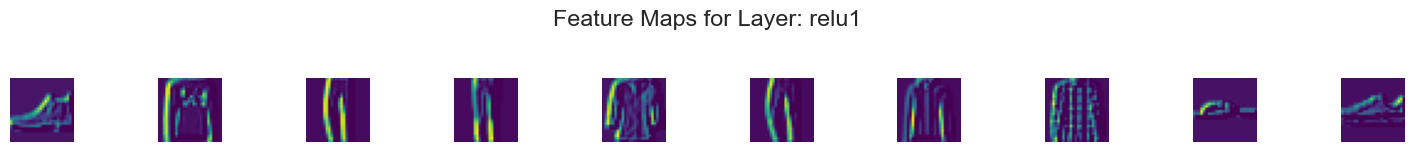

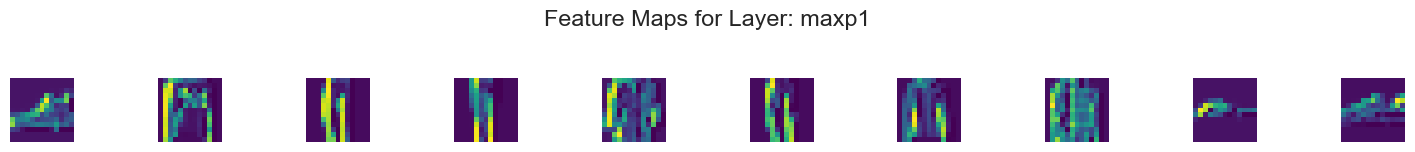

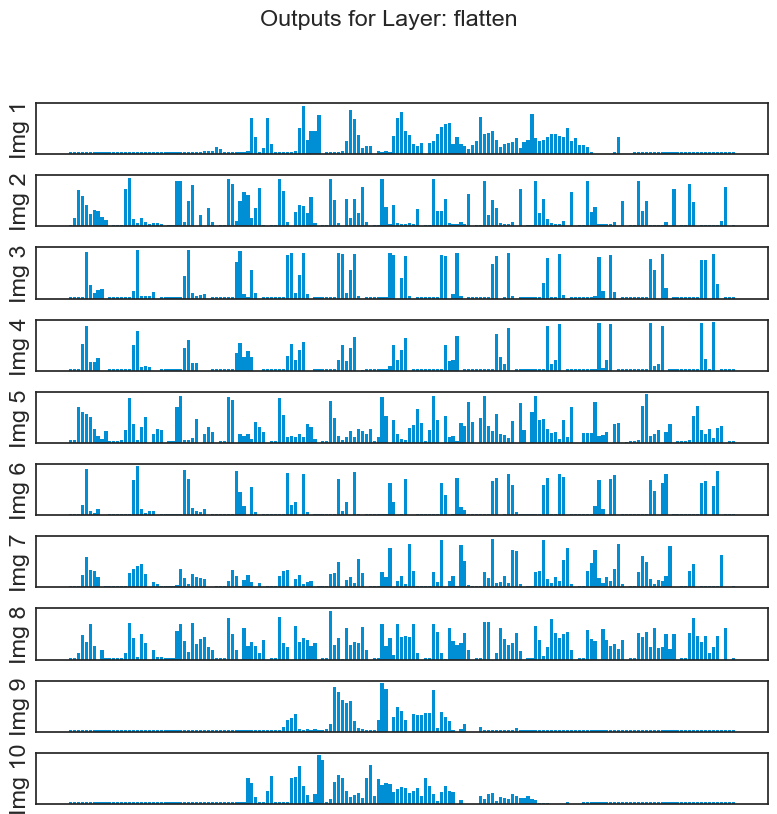


Visualizando Saídas (Classifier - Primeiras 10 Imagens):


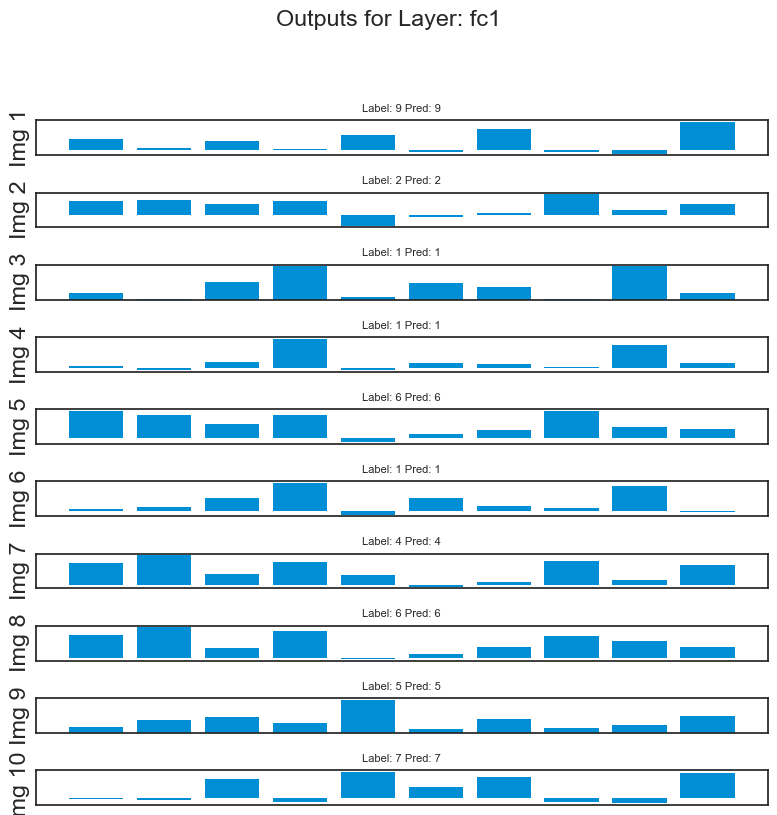

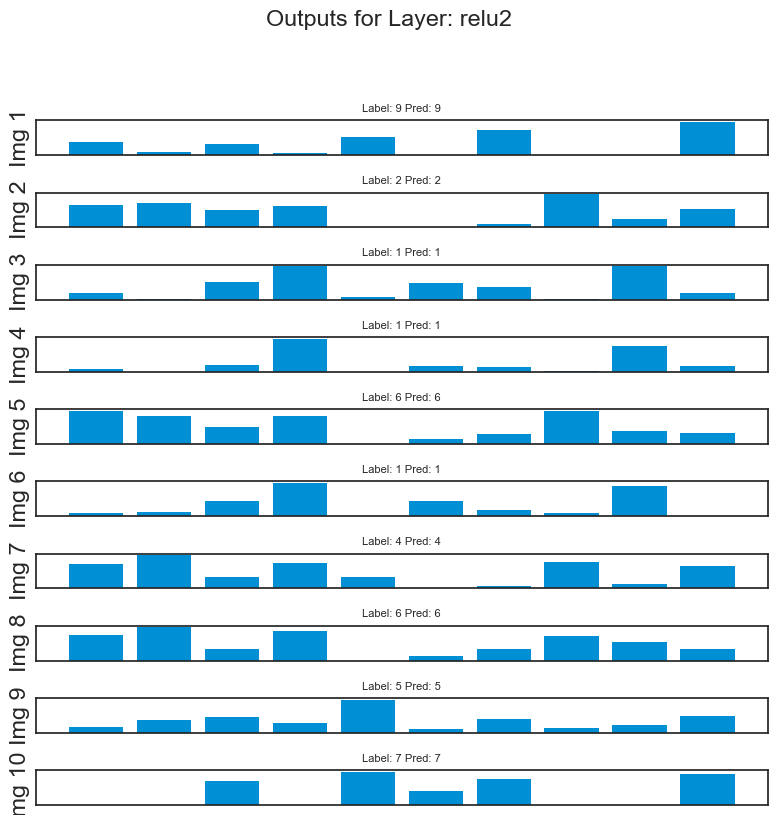

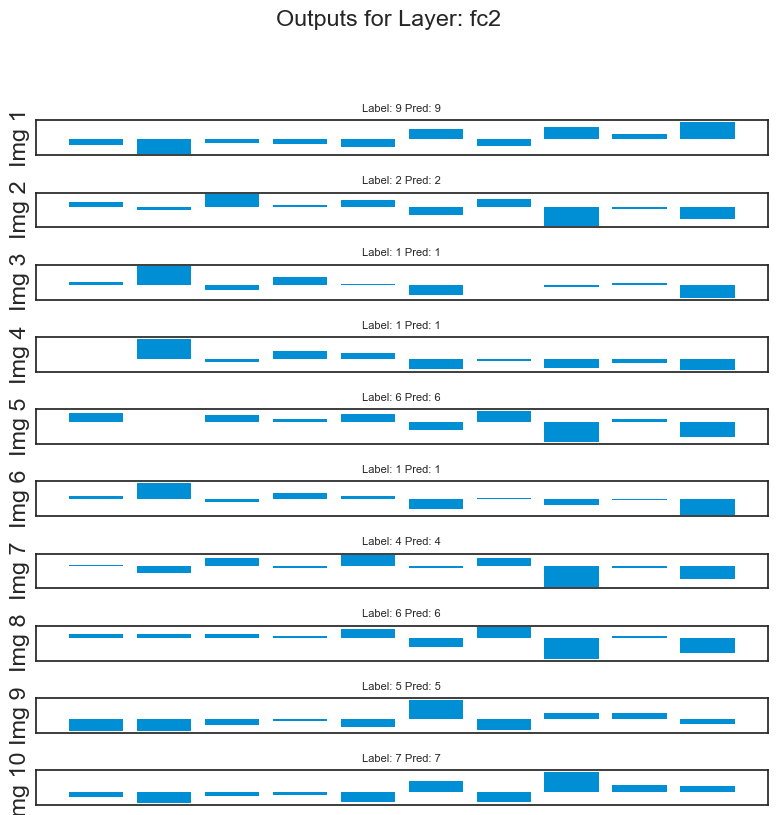

In [8]:
# Visualização do filtro conv1
fig_filter = arch_cnn1.visualize_filters('conv1', cmap='gray')
plt.show()


# --- Hooks & Feature Maps ---

# Captura um batch do Validation Loader para visualização
images_batch, labels_batch = next(iter(val_loader))

featurizer_layers = ['conv1', 'relu1', 'maxp1', 'flatten']
classifier_layers = ['fc1', 'relu2', 'fc2']

arch_cnn1.attach_hooks(layers_to_hook=featurizer_layers + classifier_layers)

# Previsão para popular os hooks
logits = arch_cnn1.predict(images_batch)
predicted = np.argmax(logits, 1)

# Visualização das Imagens de Entrada
print("\nVisualização das Imagens de Entrada:")
fig_input = plt.figure(figsize=(15, 1.5))
axs_input = fig_input.subplots(1, 10)
Architecture._visualize_tensors(axs_input,
                               images_batch.squeeze().cpu().numpy(),
                               labels_batch.cpu().numpy(),
                               predicted)
plt.tight_layout()
plt.show()
plt.close(fig_input)

# Visualização de Feature Maps e Saídas
with plt.style.context('seaborn-v0_8-white'):
    print("\nVisualizando Feature Maps (Featurizer - Primeiras 10 Imagens):")
    fig_maps1 = arch_cnn1.visualize_outputs(featurizer_layers, n_images=10)
    plt.show()

    print("\nVisualizando Saídas (Classifier - Primeiras 10 Imagens):")
    fig_maps2 = arch_cnn1.visualize_outputs(classifier_layers, y=labels_batch.cpu().numpy(), yhat=predicted, n_images=10)
    plt.show()

arch_cnn1.remove_hooks() # Moved this call to after visualizations

## Accuracy

---



In [9]:
# Acurácia no batch atual
results_batch = arch_cnn1.correct(images_batch, labels_batch)
print("Acurácia no Batch (Corretos por Classe e Total de Amostras por Classe):")
print(results_batch)

# Acurácia total no conjunto de validação (usando loader_apply)
results_val_set = Architecture.loader_apply(arch_cnn1.val_loader, arch_cnn1.correct)

print("\nAcurácia Total no Conjunto de Validação (Soma de Corretos e Somas de Amostras por Classe, para 10 classes):")
print(results_val_set)

total_correct = results_val_set[:, 0].sum().item()
total_samples = results_val_set[:, 1].sum().item()
overall_accuracy = total_correct / total_samples

print(f"\nAcurácia Total: {overall_accuracy*100:.2f}%")

Acurácia no Batch (Corretos por Classe e Total de Amostras por Classe):
tensor([[4., 4.],
        [7., 7.],
        [6., 8.],
        [2., 5.],
        [5., 8.],
        [5., 6.],
        [2., 5.],
        [8., 9.],
        [7., 8.],
        [3., 4.]])

Acurácia Total no Conjunto de Validação (Soma de Corretos e Somas de Amostras por Classe, para 10 classes):
tensor([[ 801., 1000.],
        [ 954., 1000.],
        [ 740., 1000.],
        [ 817., 1000.],
        [ 858., 1000.],
        [ 922., 1000.],
        [ 459., 1000.],
        [ 904., 1000.],
        [ 947., 1000.],
        [ 948., 1000.]])

Acurácia Total: 83.50%
